In [1]:
from tensorboard.backend.event_processing import event_accumulator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Path to your TensorBoard event file
log_dir = "../tb_logs/dqn_prb_mlp_20251014_110153"  # change this to your folder

# Load the TensorBoard data
ea = event_accumulator.EventAccumulator(log_dir)
ea.Reload()

# Check what scalar tags exist (e.g., 'train/reward', 'rollout/ep_rew_mean')
print(ea.Tags())



2025-10-16 12:36:44.076866: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-16 12:36:44.107800: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI AVX_VNNI_INT8 AVX_NE_CONVERT FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-16 12:36:44.772494: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


{'images': [], 'audio': [], 'histograms': ['actions/hist'], 'scalars': ['cell/bs_1_cell_mid_freq/reward', 'cell/bs_1_cell_mid_freq/reward_ema', 'cell/bs_1_cell_mid_freq/embb_score', 'cell/bs_1_cell_mid_freq/urllc_score', 'cell/bs_1_cell_mid_freq/mmtc_score', 'cell/bs_1_cell_mid_freq/epsilon', 'cell/bs_1_cell_mid_freq/loss', 'cell/bs_1_cell_mid_freq/prb_eMBB', 'cell/bs_1_cell_mid_freq/prb_URLLC', 'cell/bs_1_cell_mid_freq/prb_mMTC', 'cell/bs_1_cell_mid_freq/action_prev', 'cell/bs_1_cell_mid_freq/slice/eMBB/satisfaction', 'cell/bs_1_cell_mid_freq/slice/eMBB/throughput', 'cell/bs_1_cell_mid_freq/slice/eMBB/backlog', 'cell/bs_1_cell_mid_freq/slice/eMBB/oversupply', 'cell/bs_1_cell_mid_freq/slice/eMBB/idle', 'cell/bs_1_cell_mid_freq/slice/eMBB/need', 'cell/bs_1_cell_mid_freq/slice/eMBB/tx_mbps', 'cell/bs_1_cell_mid_freq/slice/eMBB/buf_bytes', 'cell/bs_1_cell_mid_freq/slice/eMBB/prb_req', 'cell/bs_1_cell_mid_freq/slice/eMBB/prb_granted', 'cell/bs_1_cell_mid_freq/slice/URLLC/satisfaction', 'ce

In [9]:
# ==========================================================
# TensorBoard Slice Analysis → Averaged Summary CSV
# ==========================================================
import pandas as pd
import os
from tensorboard.backend.event_processing import event_accumulator

# -------- RUN NAME CONFIGURATION --------
run_name = "dqn_prb_arch-lstm_seq8__seq_len-8__seq_hidden-128__move-5__period-1__batch-64__aux-h1__aux-w0.05__horizon-off_20251024_214606"

# Paths are derived automatically
log_dir = f"../tb_logs/{run_name}"
save_dir = f"runs/{run_name}"
os.makedirs(save_dir, exist_ok=True)

# -------- STEP RANGE AND BASE TAGS --------
start_step = 0
end_step = 300_000
base = "cell/bs_1_cell_mid_freq"
slices = ["eMBB", "URLLC", "mMTC", "All"]

# -------- LOAD EVENTS --------
ea = event_accumulator.EventAccumulator(log_dir)
ea.Reload()

# -------- METRICS TO EXTRACT --------
metric_groups = {
    "reward": [
        f"{base}/reward",
        f"{base}/reward_ema",
        f"{base}/loss",
        f"{base}/epsilon",
        f"{base}/prb_eMBB",
        f"{base}/prb_URLLC",
        f"{base}/prb_mMTC",
    ],
    "throughput":   [f"{base}/slice/{s}/throughput"   for s in slices],
    "tx_mbps":      [f"{base}/slice/{s}/tx_mbps"      for s in slices],
    "buf_bytes":    [f"{base}/slice/{s}/buf_bytes"    for s in slices],
    "satisfaction": [f"{base}/slice/{s}/satisfaction" for s in slices],
}

# -------- HELPER FUNCTION --------
def extract_scalars(tag):
    scalars = ea.Scalars(tag)
    if not scalars:
        return pd.DataFrame(columns=["step", "value"])
    return pd.DataFrame([(s.step, s.value) for s in scalars], columns=["step", "value"])

# -------- BUILD COMBINED DATAFRAME --------
data_dict = {}
for group, tags in metric_groups.items():
    for tag in tags:
        parts = tag.split("/")
        if "slice" in parts:
            idx = parts.index("slice")
            slice_name = parts[idx + 1]
            metric_name = parts[idx + 2]
            name = f"{slice_name}_{metric_name}"
        else:
            name = parts[-1]
        df = extract_scalars(tag)
        if not df.empty:
            data_dict[name] = df.set_index("step")["value"]

if not data_dict:
    raise RuntimeError("No scalar data found in the TensorBoard log.")

# Merge all step series
all_steps = sorted(set().union(*[df.index for df in data_dict.values()]))
merged = pd.DataFrame(index=all_steps)
for key, series in data_dict.items():
    merged[key] = series.reindex(merged.index, method="nearest")
merged.reset_index(inplace=True)
merged.rename(columns={"index": "step"}, inplace=True)

# -------- FILTER BY STEP RANGE --------
window_df = merged[(merged["step"] >= start_step) & (merged["step"] <= end_step)]
if window_df.empty:
    raise ValueError(f"No data points between {start_step} and {end_step} steps!")

# ==========================================================
# 1️⃣ COMPUTE AVERAGE SUMMARY
# ==========================================================
print(f"\n===== Averaged metrics from {start_step:,}–{end_step:,} steps =====")

summary = {"run_name": run_name}

# ---- GLOBAL METRICS ----
print("\n=========== GLOBAL METRICS ===========")
for metric in ["reward", "reward_ema", "loss", "epsilon", "prb_eMBB", "prb_URLLC", "prb_mMTC"]:
    if metric in window_df.columns:
        avg_val = window_df[metric].mean()
        summary[metric] = avg_val
        print(f"{metric:15s}: {avg_val:8.3f}")

# ---- PER-SLICE METRICS ----
print("\n=========== PER-SLICE METRICS ===========")
slice_metrics = ["throughput", "tx_mbps", "buf_bytes", "satisfaction"]

for metric in slice_metrics:
    print(f"\n--- Average {metric} per slice ---")
    for s in slices:
        col = f"{s}_{metric}"
        if col in window_df.columns:
            avg_val = window_df[col].mean()
            summary[col] = avg_val
            print(f"{col:22s}: {avg_val:10.3f}")

# ==========================================================
# 2️⃣ SAVE AVERAGE SUMMARY TO CSV
# ==========================================================
summary_df = pd.DataFrame([summary])
save_path = os.path.join(save_dir, "tensorboard_metrics_full_summary.csv")
summary_df.to_csv(save_path, index=False)

print(f"\n✅ Saved summarized metrics → {save_path}")



===== Averaged metrics from 0–300,000 steps =====

=========== GLOBAL METRICS ===========
reward         :    0.752
reward_ema     :    0.752
loss           :    0.000
epsilon        :    0.000
prb_eMBB       :    0.685
prb_URLLC      :  206.559
prb_mMTC       :    1.929

=========== PER-SLICE METRICS ===========

--- Average throughput per slice ---
eMBB_throughput       :      0.000
URLLC_throughput      :      0.001
mMTC_throughput       :      0.000
All_throughput        :      0.001

--- Average tx_mbps per slice ---
eMBB_tx_mbps          :      0.001
URLLC_tx_mbps         :      0.113
mMTC_tx_mbps          :      0.041
All_tx_mbps           :      0.155

--- Average buf_bytes per slice ---
eMBB_buf_bytes        :     11.265
URLLC_buf_bytes       :      0.000
mMTC_buf_bytes        :    182.992
All_buf_bytes         :    194.257

--- Average satisfaction per slice ---
eMBB_satisfaction     :      0.801
URLLC_satisfaction    :      0.595
mMTC_satisfaction     :      0.611
All_satis

In [10]:
# ==========================================================
# TensorBoard Slice Analysis → Averaged Summary CSV
# ==========================================================
import pandas as pd
import os
from tensorboard.backend.event_processing import event_accumulator

# -------- RUN NAME CONFIGURATION --------
run_name = "dqn_prb_arch-lstm_seq8__seq_len-8__seq_hidden-128__move-5__period-1__batch-64__aux-off__horizon-off_20251024_214603"

# Paths are derived automatically
log_dir = f"../tb_logs/{run_name}"
save_dir = f"runs/{run_name}"
os.makedirs(save_dir, exist_ok=True)

# -------- STEP RANGE AND BASE TAGS --------
start_step = 0
end_step = 300_000
base = "cell/bs_1_cell_mid_freq"
slices = ["eMBB", "URLLC", "mMTC", "All"]

# -------- LOAD EVENTS --------
ea = event_accumulator.EventAccumulator(log_dir)
ea.Reload()

# -------- METRICS TO EXTRACT --------
metric_groups = {
    "reward": [
        f"{base}/reward",
        f"{base}/reward_ema",
        f"{base}/loss",
        f"{base}/epsilon",
        f"{base}/prb_eMBB",
        f"{base}/prb_URLLC",
        f"{base}/prb_mMTC",
    ],
    "throughput":   [f"{base}/slice/{s}/throughput"   for s in slices],
    "tx_mbps":      [f"{base}/slice/{s}/tx_mbps"      for s in slices],
    "buf_bytes":    [f"{base}/slice/{s}/buf_bytes"    for s in slices],
    "satisfaction": [f"{base}/slice/{s}/satisfaction" for s in slices],
}

# -------- HELPER FUNCTION --------
def extract_scalars(tag):
    scalars = ea.Scalars(tag)
    if not scalars:
        return pd.DataFrame(columns=["step", "value"])
    return pd.DataFrame([(s.step, s.value) for s in scalars], columns=["step", "value"])

# -------- BUILD COMBINED DATAFRAME --------
data_dict = {}
for group, tags in metric_groups.items():
    for tag in tags:
        parts = tag.split("/")
        if "slice" in parts:
            idx = parts.index("slice")
            slice_name = parts[idx + 1]
            metric_name = parts[idx + 2]
            name = f"{slice_name}_{metric_name}"
        else:
            name = parts[-1]
        df = extract_scalars(tag)
        if not df.empty:
            data_dict[name] = df.set_index("step")["value"]

if not data_dict:
    raise RuntimeError("No scalar data found in the TensorBoard log.")

# Merge all step series
all_steps = sorted(set().union(*[df.index for df in data_dict.values()]))
merged = pd.DataFrame(index=all_steps)
for key, series in data_dict.items():
    merged[key] = series.reindex(merged.index, method="nearest")
merged.reset_index(inplace=True)
merged.rename(columns={"index": "step"}, inplace=True)

# -------- FILTER BY STEP RANGE --------
window_df = merged[(merged["step"] >= start_step) & (merged["step"] <= end_step)]
if window_df.empty:
    raise ValueError(f"No data points between {start_step} and {end_step} steps!")

# ==========================================================
# 1️⃣ COMPUTE AVERAGE SUMMARY
# ==========================================================
print(f"\n===== Averaged metrics from {start_step:,}–{end_step:,} steps =====")

summary = {"run_name": run_name}

# ---- GLOBAL METRICS ----
print("\n=========== GLOBAL METRICS ===========")
for metric in ["reward", "reward_ema", "loss", "epsilon", "prb_eMBB", "prb_URLLC", "prb_mMTC"]:
    if metric in window_df.columns:
        avg_val = window_df[metric].mean()
        summary[metric] = avg_val
        print(f"{metric:15s}: {avg_val:8.3f}")

# ---- PER-SLICE METRICS ----
print("\n=========== PER-SLICE METRICS ===========")
slice_metrics = ["throughput", "tx_mbps", "buf_bytes", "satisfaction"]

for metric in slice_metrics:
    print(f"\n--- Average {metric} per slice ---")
    for s in slices:
        col = f"{s}_{metric}"
        if col in window_df.columns:
            avg_val = window_df[col].mean()
            summary[col] = avg_val
            print(f"{col:22s}: {avg_val:10.3f}")

# ==========================================================
# 2️⃣ SAVE AVERAGE SUMMARY TO CSV
# ==========================================================
summary_df = pd.DataFrame([summary])
save_path = os.path.join(save_dir, "tensorboard_metrics_full_summary.csv")
summary_df.to_csv(save_path, index=False)

print(f"\n✅ Saved summarized metrics → {save_path}")



===== Averaged metrics from 0–300,000 steps =====

=========== GLOBAL METRICS ===========
reward         :    0.742
reward_ema     :    0.740
loss           :    0.000
epsilon        :    0.000
prb_eMBB       :    0.817
prb_URLLC      :    9.817
prb_mMTC       :    3.185

=========== PER-SLICE METRICS ===========

--- Average throughput per slice ---
eMBB_throughput       :      0.000
URLLC_throughput      :      0.001
mMTC_throughput       :      0.000
All_throughput        :      0.001

--- Average tx_mbps per slice ---
eMBB_tx_mbps          :      0.001
URLLC_tx_mbps         :      0.112
mMTC_tx_mbps          :      0.043
All_tx_mbps           :      0.156

--- Average buf_bytes per slice ---
eMBB_buf_bytes        :      6.667
URLLC_buf_bytes       :     74.665
mMTC_buf_bytes        :    116.286
All_buf_bytes         :    197.618

--- Average satisfaction per slice ---
eMBB_satisfaction     :      0.859
URLLC_satisfaction    :      0.616
mMTC_satisfaction     :      0.629
All_satis

In [11]:
# ==========================================================
# TensorBoard Slice Analysis → Averaged Summary CSV
# ==========================================================
import pandas as pd
import os
from tensorboard.backend.event_processing import event_accumulator

# -------- RUN NAME CONFIGURATION --------
run_name = "dqn_prb_arch-mlp__move-5__period-1__batch-64__aux-off__horizon-off_20251024_214559"

# Paths are derived automatically
log_dir = f"../tb_logs/{run_name}"
save_dir = f"runs/{run_name}"
os.makedirs(save_dir, exist_ok=True)

# -------- STEP RANGE AND BASE TAGS --------
start_step = 0
end_step = 300_000
base = "cell/bs_1_cell_mid_freq"
slices = ["eMBB", "URLLC", "mMTC", "All"]

# -------- LOAD EVENTS --------
ea = event_accumulator.EventAccumulator(log_dir)
ea.Reload()

# -------- METRICS TO EXTRACT --------
metric_groups = {
    "reward": [
        f"{base}/reward",
        f"{base}/reward_ema",
        f"{base}/loss",
        f"{base}/epsilon",
        f"{base}/prb_eMBB",
        f"{base}/prb_URLLC",
        f"{base}/prb_mMTC",
    ],
    "throughput":   [f"{base}/slice/{s}/throughput"   for s in slices],
    "tx_mbps":      [f"{base}/slice/{s}/tx_mbps"      for s in slices],
    "buf_bytes":    [f"{base}/slice/{s}/buf_bytes"    for s in slices],
    "satisfaction": [f"{base}/slice/{s}/satisfaction" for s in slices],
}

# -------- HELPER FUNCTION --------
def extract_scalars(tag):
    scalars = ea.Scalars(tag)
    if not scalars:
        return pd.DataFrame(columns=["step", "value"])
    return pd.DataFrame([(s.step, s.value) for s in scalars], columns=["step", "value"])

# -------- BUILD COMBINED DATAFRAME --------
data_dict = {}
for group, tags in metric_groups.items():
    for tag in tags:
        parts = tag.split("/")
        if "slice" in parts:
            idx = parts.index("slice")
            slice_name = parts[idx + 1]
            metric_name = parts[idx + 2]
            name = f"{slice_name}_{metric_name}"
        else:
            name = parts[-1]
        df = extract_scalars(tag)
        if not df.empty:
            data_dict[name] = df.set_index("step")["value"]

if not data_dict:
    raise RuntimeError("No scalar data found in the TensorBoard log.")

# Merge all step series
all_steps = sorted(set().union(*[df.index for df in data_dict.values()]))
merged = pd.DataFrame(index=all_steps)
for key, series in data_dict.items():
    merged[key] = series.reindex(merged.index, method="nearest")
merged.reset_index(inplace=True)
merged.rename(columns={"index": "step"}, inplace=True)

# -------- FILTER BY STEP RANGE --------
window_df = merged[(merged["step"] >= start_step) & (merged["step"] <= end_step)]
if window_df.empty:
    raise ValueError(f"No data points between {start_step} and {end_step} steps!")

# ==========================================================
# 1️⃣ COMPUTE AVERAGE SUMMARY
# ==========================================================
print(f"\n===== Averaged metrics from {start_step:,}–{end_step:,} steps =====")

summary = {"run_name": run_name}

# ---- GLOBAL METRICS ----
print("\n=========== GLOBAL METRICS ===========")
for metric in ["reward", "reward_ema", "loss", "epsilon", "prb_eMBB", "prb_URLLC", "prb_mMTC"]:
    if metric in window_df.columns:
        avg_val = window_df[metric].mean()
        summary[metric] = avg_val
        print(f"{metric:15s}: {avg_val:8.3f}")

# ---- PER-SLICE METRICS ----
print("\n=========== PER-SLICE METRICS ===========")
slice_metrics = ["throughput", "tx_mbps", "buf_bytes", "satisfaction"]

for metric in slice_metrics:
    print(f"\n--- Average {metric} per slice ---")
    for s in slices:
        col = f"{s}_{metric}"
        if col in window_df.columns:
            avg_val = window_df[col].mean()
            summary[col] = avg_val
            print(f"{col:22s}: {avg_val:10.3f}")

# ==========================================================
# 2️⃣ SAVE AVERAGE SUMMARY TO CSV
# ==========================================================
summary_df = pd.DataFrame([summary])
save_path = os.path.join(save_dir, "tensorboard_metrics_full_summary.csv")
summary_df.to_csv(save_path, index=False)

print(f"\n✅ Saved summarized metrics → {save_path}")



===== Averaged metrics from 0–300,000 steps =====

=========== GLOBAL METRICS ===========
reward         :    0.559
reward_ema     :    0.558
loss           :    0.000
epsilon        :    0.000
prb_eMBB       :   30.177
prb_URLLC      :  187.077
prb_mMTC       :    0.320

=========== PER-SLICE METRICS ===========

--- Average throughput per slice ---
eMBB_throughput       :      0.000
URLLC_throughput      :      0.001
mMTC_throughput       :      0.000
All_throughput        :      0.001

--- Average tx_mbps per slice ---
eMBB_tx_mbps          :      0.001
URLLC_tx_mbps         :      0.114
mMTC_tx_mbps          :      0.039
All_tx_mbps           :      0.155

--- Average buf_bytes per slice ---
eMBB_buf_bytes        :    136.821
URLLC_buf_bytes       :   8925.867
mMTC_buf_bytes        :  80434.400
All_buf_bytes         :  89497.088

--- Average satisfaction per slice ---
eMBB_satisfaction     :      0.434
URLLC_satisfaction    :      0.523
mMTC_satisfaction     :      0.022
All_satis

In [ ]:
# ==========================================================
# TensorBoard Slice Analysis → Averaged Summary CSV
# ==========================================================
import pandas as pd
import os
from tensorboard.backend.event_processing import event_accumulator

# -------- RUN NAME CONFIGURATION --------
run_name = "dqn_prb_arch-lstm_seq8__seq_len-8__seq_hidden-128__move-5__period-1__batch-64__aux-off__horizon-off_20251024_214603"

# Paths are derived automatically
log_dir = f"../tb_logs/{run_name}"
save_dir = f"runs/{run_name}"
os.makedirs(save_dir, exist_ok=True)

# -------- STEP RANGE AND BASE TAGS --------
start_step = 0
end_step = 250_000
base = "cell/bs_1_cell_mid_freq"
slices = ["eMBB", "URLLC", "mMTC", "All"]

# -------- LOAD EVENTS --------
ea = event_accumulator.EventAccumulator(log_dir)
ea.Reload()

# -------- METRICS TO EXTRACT --------
metric_groups = {
    "reward": [
        f"{base}/reward",
        f"{base}/reward_ema",
        f"{base}/loss",
        f"{base}/epsilon",
        f"{base}/prb_eMBB",
        f"{base}/prb_URLLC",
        f"{base}/prb_mMTC",
    ],
    "throughput":   [f"{base}/slice/{s}/throughput"   for s in slices],
    "tx_mbps":      [f"{base}/slice/{s}/tx_mbps"      for s in slices],
    "buf_bytes":    [f"{base}/slice/{s}/buf_bytes"    for s in slices],
    "satisfaction": [f"{base}/slice/{s}/satisfaction" for s in slices],
}

# -------- HELPER FUNCTION --------
def extract_scalars(tag):
    scalars = ea.Scalars(tag)
    if not scalars:
        return pd.DataFrame(columns=["step", "value"])
    return pd.DataFrame([(s.step, s.value) for s in scalars], columns=["step", "value"])

# -------- BUILD COMBINED DATAFRAME --------
data_dict = {}
for group, tags in metric_groups.items():
    for tag in tags:
        parts = tag.split("/")
        if "slice" in parts:
            idx = parts.index("slice")
            slice_name = parts[idx + 1]
            metric_name = parts[idx + 2]
            name = f"{slice_name}_{metric_name}"
        else:
            name = parts[-1]
        df = extract_scalars(tag)
        if not df.empty:
            data_dict[name] = df.set_index("step")["value"]

if not data_dict:
    raise RuntimeError("No scalar data found in the TensorBoard log.")

# Merge all step series
all_steps = sorted(set().union(*[df.index for df in data_dict.values()]))
merged = pd.DataFrame(index=all_steps)
for key, series in data_dict.items():
    merged[key] = series.reindex(merged.index, method="nearest")
merged.reset_index(inplace=True)
merged.rename(columns={"index": "step"}, inplace=True)

# -------- FILTER BY STEP RANGE --------
window_df = merged[(merged["step"] >= start_step) & (merged["step"] <= end_step)]
if window_df.empty:
    raise ValueError(f"No data points between {start_step} and {end_step} steps!")

# ==========================================================
# 1️⃣ COMPUTE AVERAGE SUMMARY
# ==========================================================
print(f"\n===== Averaged metrics from {start_step:,}–{end_step:,} steps =====")

summary = {"run_name": run_name}

# ---- GLOBAL METRICS ----
print("\n=========== GLOBAL METRICS ===========")
for metric in ["reward", "reward_ema", "loss", "epsilon", "prb_eMBB", "prb_URLLC", "prb_mMTC"]:
    if metric in window_df.columns:
        avg_val = window_df[metric].mean()
        summary[metric] = avg_val
        print(f"{metric:15s}: {avg_val:8.3f}")

# ---- PER-SLICE METRICS ----
print("\n=========== PER-SLICE METRICS ===========")
slice_metrics = ["throughput", "tx_mbps", "buf_bytes", "satisfaction"]

for metric in slice_metrics:
    print(f"\n--- Average {metric} per slice ---")
    for s in slices:
        col = f"{s}_{metric}"
        if col in window_df.columns:
            avg_val = window_df[col].mean()
            summary[col] = avg_val
            print(f"{col:22s}: {avg_val:10.3f}")

# ==========================================================
# 2️⃣ SAVE AVERAGE SUMMARY TO CSV
# ==========================================================
summary_df = pd.DataFrame([summary])
save_path = os.path.join(save_dir, "tensorboard_metrics_full_summary.csv")
summary_df.to_csv(save_path, index=False)

print(f"\n✅ Saved summarized metrics → {save_path}")


### Load the csv

In [12]:
import pandas as pd
import glob
import os

# --------------------------------------------------
# Load all summarized CSV files
# --------------------------------------------------
csv_files = glob.glob("runs/**/tensorboard_metrics_full_summary.csv", recursive=True)

dataframes = []
for file in csv_files:
    df = pd.read_csv(file)
    dataframes.append(df)

# Combine all into one big table
all_data = pd.concat(dataframes, ignore_index=True)
print(all_data.columns)
#print(all_data[["run_name", "reward", "slice_tx_mbps", "slice_buf_bytes", "slice_satisfaction"]])
print(all_data[["run_name", "reward", "All_tx_mbps", "All_buf_bytes", "All_satisfaction"]])


Index(['run_name', 'reward', 'reward_ema', 'loss', 'epsilon', 'prb_eMBB',
       'prb_URLLC', 'prb_mMTC', 'eMBB_throughput', 'URLLC_throughput',
       'mMTC_throughput', 'All_throughput', 'eMBB_tx_mbps', 'URLLC_tx_mbps',
       'mMTC_tx_mbps', 'All_tx_mbps', 'eMBB_buf_bytes', 'URLLC_buf_bytes',
       'mMTC_buf_bytes', 'All_buf_bytes', 'eMBB_satisfaction',
       'URLLC_satisfaction', 'mMTC_satisfaction', 'All_satisfaction'],
      dtype='object')
                                            run_name    reward  All_tx_mbps  \
0  dqn_prb_arch-lstm_seq8__seq_len-8__seq_hidden-...  0.751898     0.155152   
1  dqn_prb_arch-lstm_seq8__seq_len-8__seq_hidden-...  0.742210     0.155845   
2  dqn_prb_arch-mlp__move-5__period-1__batch-64__...  0.559196     0.154577   

   All_buf_bytes  All_satisfaction  
0     194.256585          0.668957  
1     197.617911          0.701543  
2   89497.087524          0.326454  


/tmp/ipykernel_1500420/2583274852.py:49: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


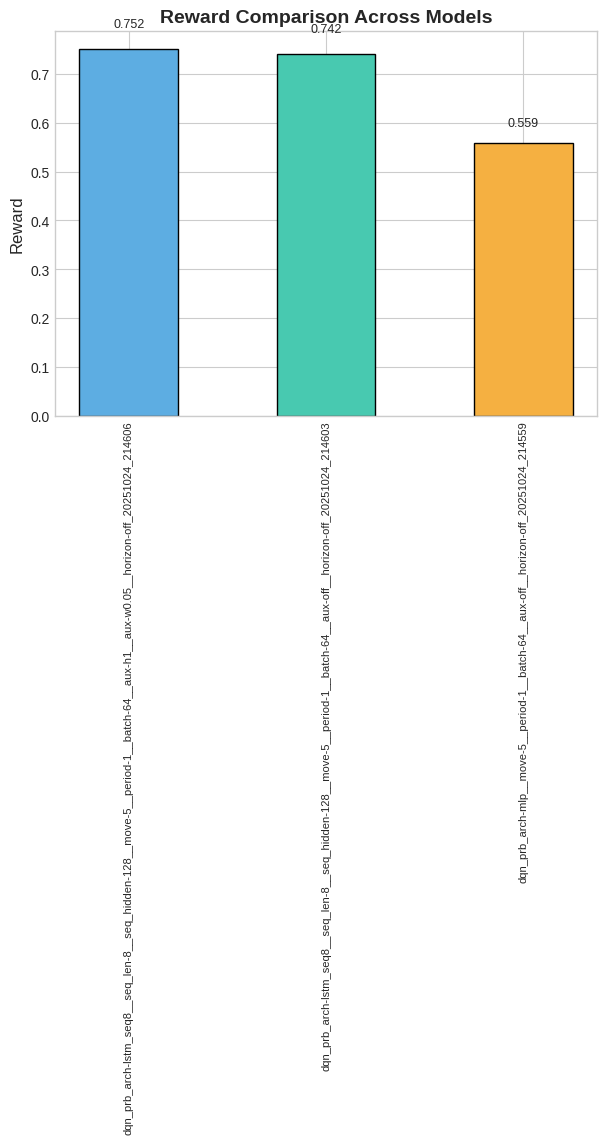

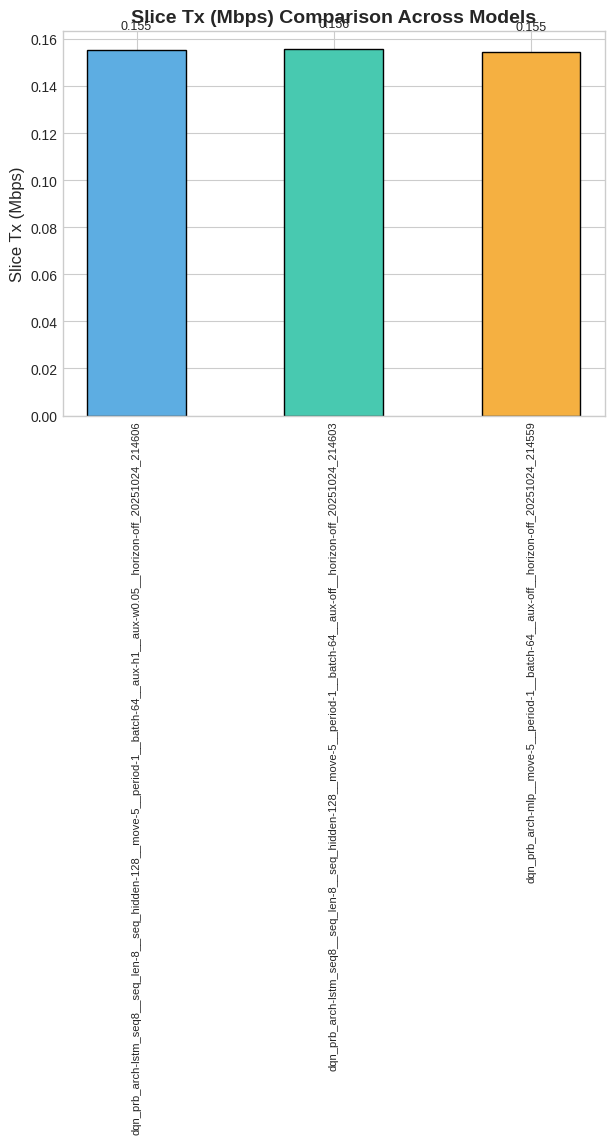

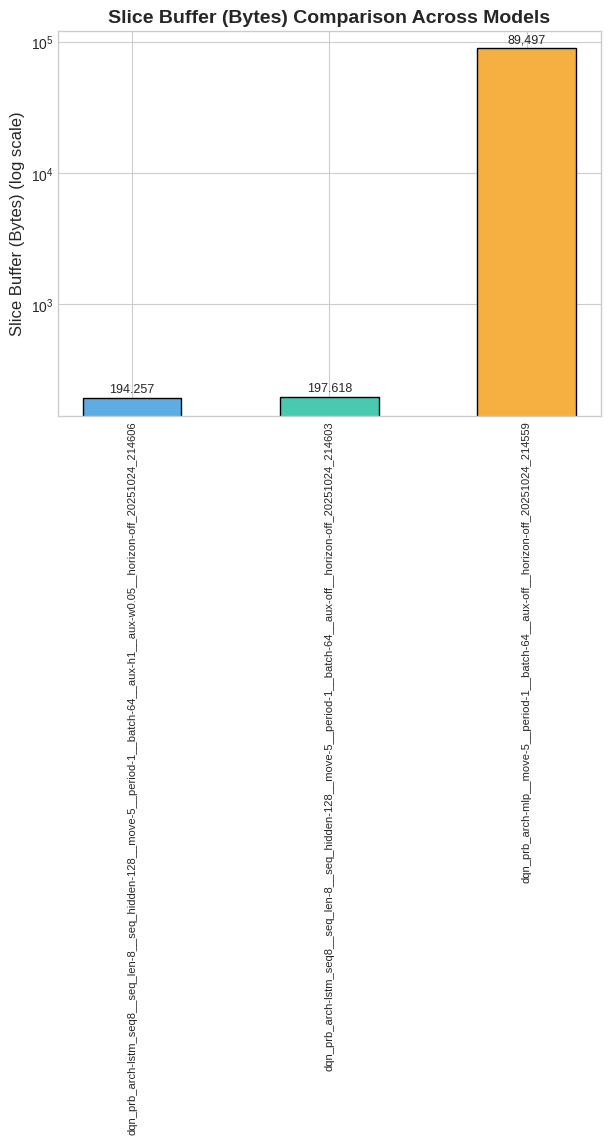

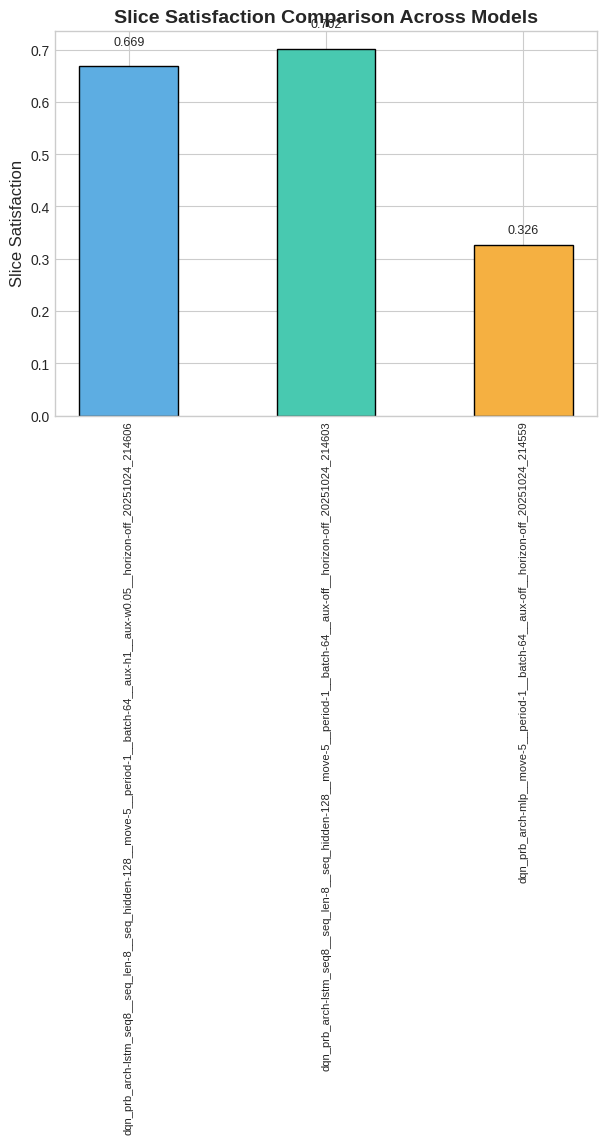

In [15]:
import matplotlib.pyplot as plt

# --------------------------------------------------
# Extract aggregate metrics
# --------------------------------------------------
models = all_data["run_name"].tolist()

metrics = {
    "Reward": all_data["reward"].tolist(),
    "Slice Tx (Mbps)": all_data["All_tx_mbps"].tolist(),
    "Slice Buffer (Bytes)": all_data["All_buf_bytes"].tolist(),
    "Slice Satisfaction": all_data["All_satisfaction"].tolist()
}

# --------------------------------------------------
# Plot each metric separately
# --------------------------------------------------
plt.style.use("seaborn-v0_8-whitegrid")

for metric_name, values in metrics.items():
    plt.figure(figsize=(7, 5))
    bars = plt.bar(
        models,
        values,
        color=["#5DADE2", "#48C9B0", "#F5B041", "#AF7AC5"],
        width=0.5,
        edgecolor='black'
    )

    plt.title(f"{metric_name} Comparison Across Models", fontsize=14, fontweight='bold')
    plt.ylabel(metric_name, fontsize=12)
    #plt.xticks(rotation=30, ha="right", fontsize=10)
    plt.xticks(rotation=90, ha="center", fontsize=8)


    if "Buffer" in metric_name:
        plt.yscale("log")
        plt.ylabel(f"{metric_name} (log scale)", fontsize=12)

    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval * (1.05 if yval > 0 else 0.95),
            f"{yval:.3f}" if yval < 1000 else f"{yval:,.0f}",
            ha='center', va='bottom', fontsize=9
        )

    plt.tight_layout()
    plt.show()


/tmp/ipykernel_1500420/799349700.py:57: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


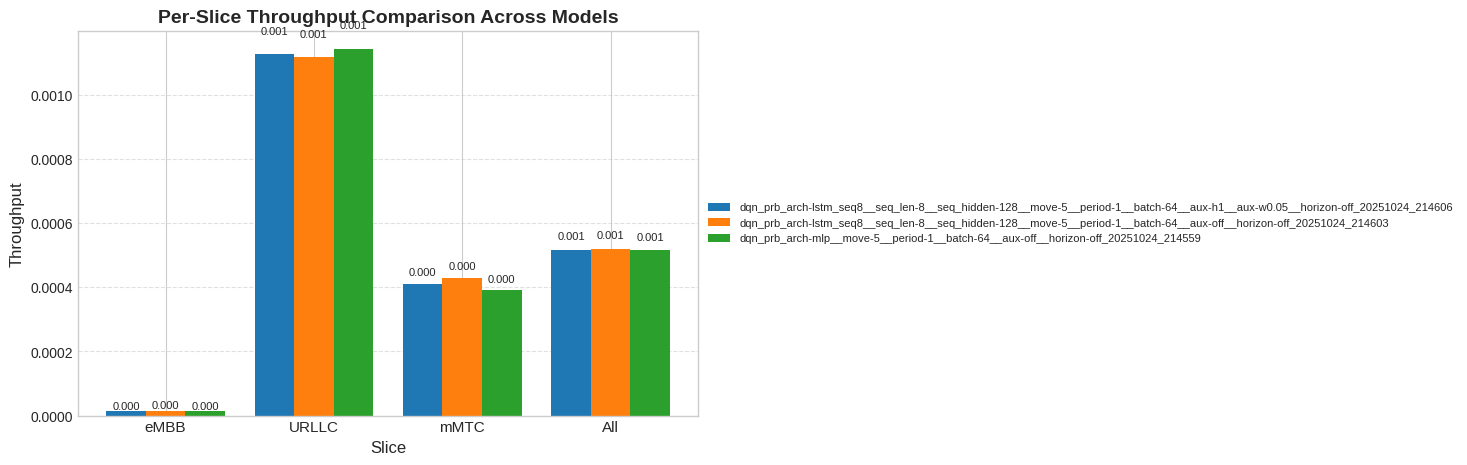

/tmp/ipykernel_1500420/799349700.py:57: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


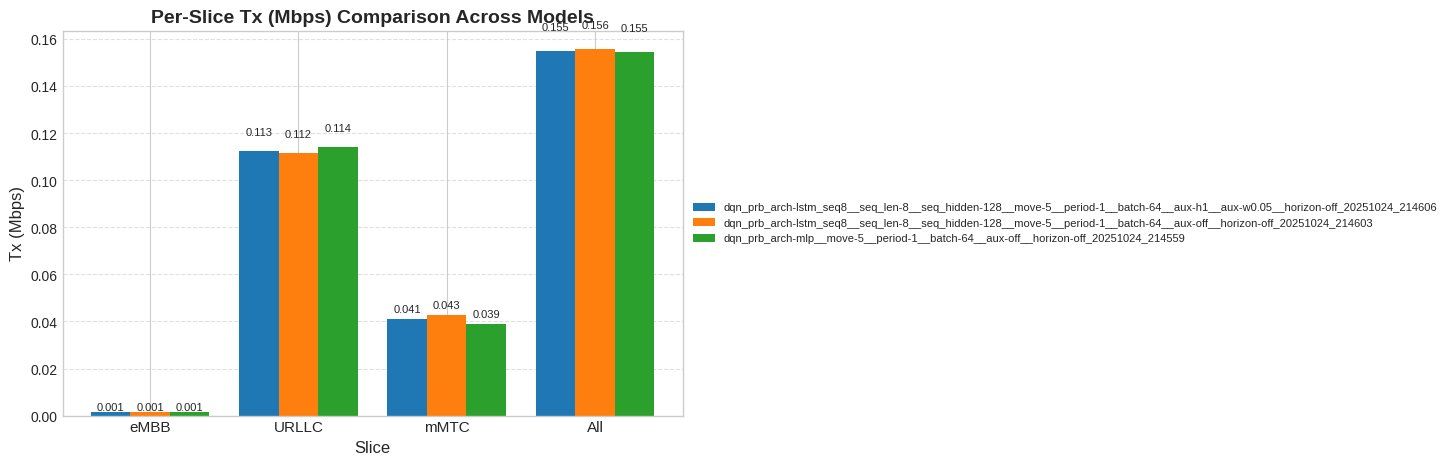

/tmp/ipykernel_1500420/799349700.py:57: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


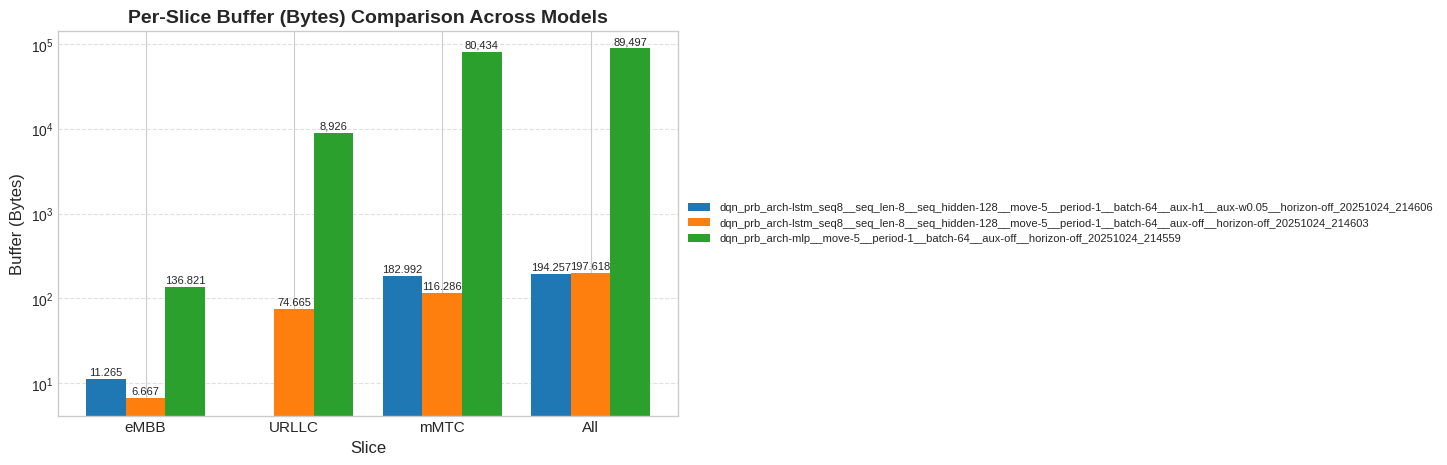

/tmp/ipykernel_1500420/799349700.py:57: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


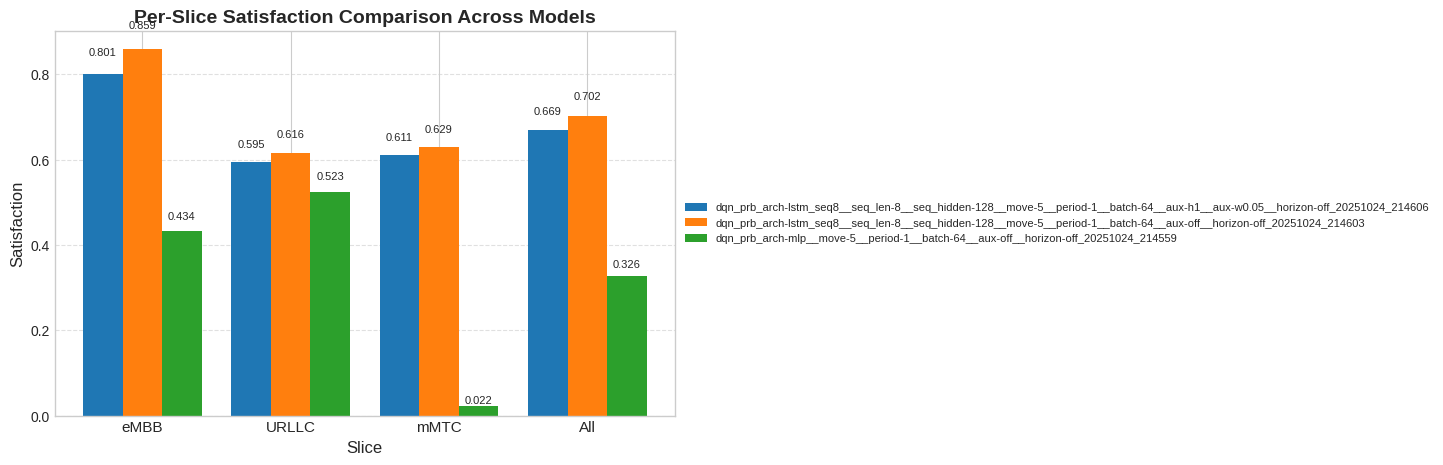

In [22]:
import numpy as np

# --------------------------------------------------
# Define slices and per-slice metrics
# --------------------------------------------------
slices = ["eMBB", "URLLC", "mMTC", "All"]
slice_metric_groups = {
    "Throughput": [f"{s}_throughput" for s in slices],
    "Tx (Mbps)": [f"{s}_tx_mbps" for s in slices],
    "Buffer (Bytes)": [f"{s}_buf_bytes" for s in slices],
    "Satisfaction": [f"{s}_satisfaction" for s in slices],
}

# --------------------------------------------------
# Plot per-slice metrics
# --------------------------------------------------
plt.style.use("seaborn-v0_8-whitegrid")

for metric_name, cols in slice_metric_groups.items():
    plt.figure(figsize=(8, 5))
    x = np.arange(len(slices))
    width = 0.8 / len(all_data)  # space bars evenly for any number of runs

    # Log scale for buffer because of large differences
    if "Buffer" in metric_name:
        plt.yscale("log")

    # Plot bars for each model/run
    for i, (_, row) in enumerate(all_data.iterrows()):
        values = [row.get(c, 0) for c in cols]
        plt.bar(x + i * width - (len(all_data) / 2) * width + width / 2,
                values, width, label=row["run_name"])

    plt.title(f"Per-Slice {metric_name} Comparison Across Models", fontsize=14, fontweight='bold')
    plt.xlabel("Slice", fontsize=12)
    plt.ylabel(metric_name, fontsize=12)
    plt.xticks(x, slices, fontsize=11)
    #plt.xticks(x, slices, rotation=90, ha="center", fontsize=9)

    #plt.legend(fontsize=9)
    #plt.legend(fontsize=8, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
    plt.legend(fontsize=8, loc='center left', bbox_to_anchor=(1, 0.5))


    plt.grid(axis="y", linestyle="--", alpha=0.6)

    # Add value annotations
    for i, (_, row) in enumerate(all_data.iterrows()):
        values = [row.get(c, 0) for c in cols]
        for j, val in enumerate(values):
            if val == 0: continue
            offset = val * 0.05 if val != 0 else 0.0001
            text = f"{val:.3f}" if val < 1000 else f"{val:,.0f}"
            plt.text(x[j] + i * width - (len(all_data) / 2) * width + width / 2,
                     val + offset, text, ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()
